In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
df = pd.read_csv("final_data.csv")

print("Dataset Info:")
df.info()

df.head()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         4018 non-null   int64  
 1   Station1_CO        4018 non-null   float64
 2   Station1_NO2       4018 non-null   float64
 3   Station1_NOx       4018 non-null   float64
 4   Station1_PM10      4018 non-null   float64
 5   Station1_SO2       4018 non-null   float64
 6   Station2_CO        4018 non-null   float64
 7   Station2_NO2       4018 non-null   float64
 8   Station2_NOx       4018 non-null   float64
 9   Station2_O3        4018 non-null   float64
 10  Station2_PM10      4018 non-null   float64
 11  Station2_SO2       4018 non-null   float64
 12  temp               4018 non-null   float64
 13  humidity           4018 non-null   float64
 14  precip             4018 non-null   float64
 15  precipcover        4018 non-null   float64
 16  cloudcover

,Unnamed: 0,Station1_CO,Station1_NO2,Station1_NOx,Station1_PM10,Station1_SO2,Station2_CO,Station2_NO2,Station2_NOx,Station2_O3,...,windspeed,visibility,is_heating_season,is_work_day,winddir_sin,winddir_cos,Date,year,month,day
0,0,1057.0,31.3,67.6,56.0,6.96,1121.0,19.9,27.5,9.3,...,7.3,2.6,1,1,0.979223,-0.202787,2014-01-01,2014,1,1
1,1,1030.0,37.0,89.1,60.0,11.12,1212.0,25.9,44.4,9.9,...,10.9,6.4,1,1,0.685818,-0.727773,2014-01-02,2014,1,2
2,2,1319.0,49.1,196.1,69.0,10.18,1292.0,26.3,60.5,7.5,...,14.3,11.0,1,1,0.068015,-0.997684,2014-01-03,2014,1,3
3,3,1001.0,36.9,94.8,46.0,11.66,952.0,21.6,27.3,7.6,...,17.9,8.0,1,0,0.432086,-0.901833,2014-01-04,2014,1,4
4,4,1155.0,37.3,102.6,39.0,9.32,1001.0,23.4,36.6,12.5,...,21.4,18.0,1,0,0.436802,-0.899558,2014-01-05,2014,1,5


In [3]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
features = [
    "Station1_CO", "Station1_NO2", "Station1_NOx",
    "Station2_CO", "Station2_NO2", "Station2_NOx", "Station2_O3",
    "Station1_SO2", "Station2_SO2",
    "Station1_PM10", "temp", "humidity", "precip",
    "precipcover", "cloudcover", "windspeed", "visibility",
    "winddir_sin", "winddir_cos", "is_heating_season", "is_work_day",
    "year", "month", "day"
]
target = "Station2_PM10"

print("\nMissing values:")
print(df[features + [target]].isnull().sum())


Missing values:
Station1_CO          0
Station1_NO2         0
Station1_NOx         0
Station2_CO          0
Station2_NO2         0
Station2_NOx         0
Station2_O3          0
Station1_SO2         0
Station2_SO2         0
Station1_PM10        0
temp                 0
humidity             0
precip               0
precipcover          0
cloudcover           0
windspeed            0
visibility           0
winddir_sin          0
winddir_cos          0
is_heating_season    0
is_work_day          0
year                 0
month                0
day                  0
Station2_PM10        0
dtype: int64


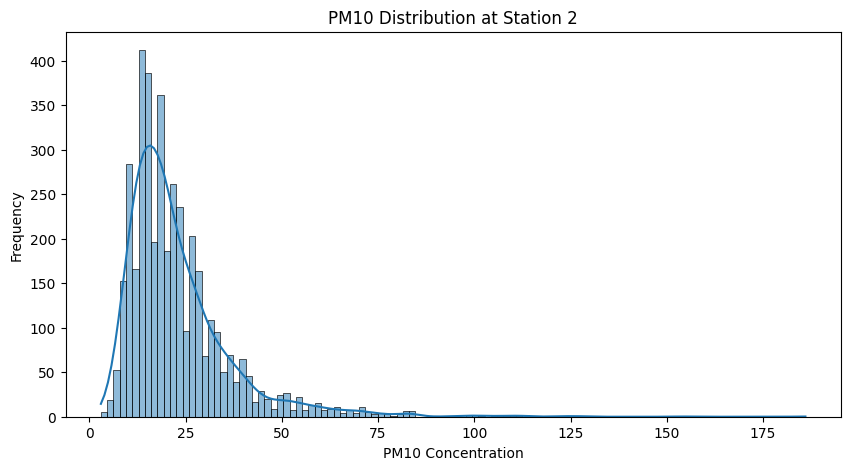

In [5]:
plt.figure(figsize=(10, 5))
sns.histplot(df[target], kde=True)
plt.title('PM10 Distribution at Station 2')
plt.xlabel('PM10 Concentration')
plt.ylabel('Frequency')
plt.show()

In [6]:
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def create_sequences(data, targets, time_steps=30):
    X_seq, y_seq = [], []
    for i in range(time_steps, len(data)):
        X_seq.append(data[i - time_steps:i, :])
        y_seq.append(targets[i])
    return np.array(X_seq), np.array(y_seq)

time_steps = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training sequences shape: {X_train_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Training data shape: (3214, 24)
Test data shape: (804, 24)
Training sequences shape: (3184, 30, 24)
Test sequences shape: (774, 30, 24)


In [7]:
print("Training GBDT model...")
gbdt = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    min_samples_split=5,
    random_state=42,
    verbose=1
)
gbdt.fit(X_train_scaled, y_train)

Training GBDT model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1         190.5763          20.1454           14.56s
         2         181.6350          52.9451           13.40s
         3         161.1696          -1.1185           11.93s
         4         148.8448          23.6345           11.18s
         5         142.0878          39.4682           10.71s
         6         127.2373           0.1096           10.50s
         7         111.7513          -7.1005           10.33s
         8         103.2600          16.0545           10.15s
         9          93.3739           5.2878            9.97s
        10          89.0790          23.6882            9.87s
        20          39.7726          -1.4859            9.31s
        30          20.1003           2.0851            8.77s
        40          12.3017           0.4917            8.35s
        50           8.9834           1.5499            7.97s
        60           7.1161           1.6527  

GradientBoostingRegressor(learning_rate=0.05, max_depth=6, min_samples_split=5,
                          n_estimators=300, random_state=42, subsample=0.8,
                          verbose=1)


GBDT Performance:
MSE: 25.2092
MAE: 3.2542
R2: 0.7726


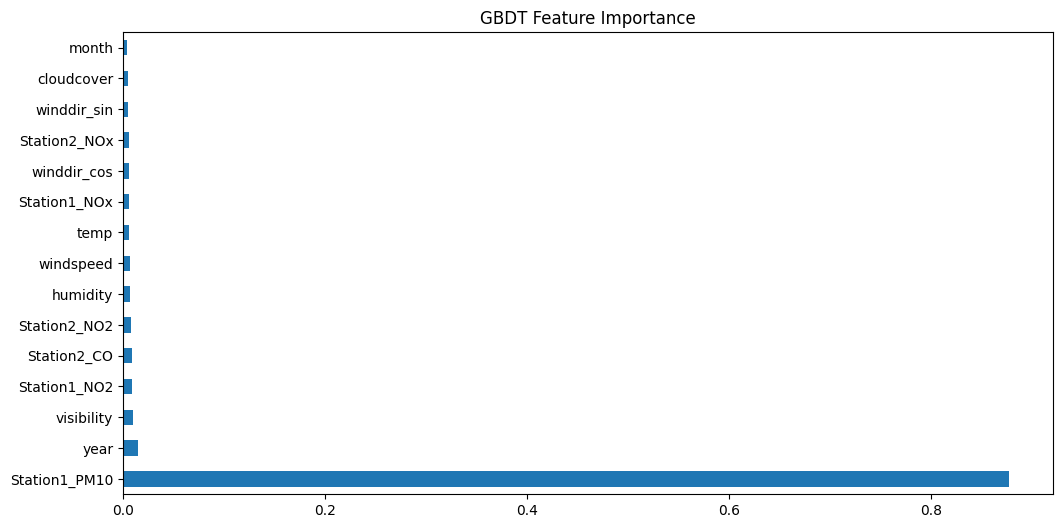

In [8]:
gbdt_pred = gbdt.predict(X_test_scaled)
gbdt_mse = mean_squared_error(y_test, gbdt_pred)
gbdt_mae = mean_absolute_error(y_test, gbdt_pred)
gbdt_r2 = r2_score(y_test, gbdt_pred)

print(f"\nGBDT Performance:")
print(f"MSE: {gbdt_mse:.4f}")
print(f"MAE: {gbdt_mae:.4f}")
print(f"R2: {gbdt_r2:.4f}")

plt.figure(figsize=(12, 6))
feat_importances = pd.Series(gbdt.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('GBDT Feature Importance')
plt.show()

In [9]:
print("Training DART model...")
dart = LGBMRegressor(
    boosting_type='dart',
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    drop_rate=0.1,
    random_state=42,
    verbose=-1
)
dart.fit(X_train_scaled, y_train)

Training DART model...


LGBMRegressor(boosting_type='dart', colsample_bytree=0.8, drop_rate=0.1,
              learning_rate=0.05, max_depth=5, n_estimators=300,
              random_state=42, subsample=0.8, verbose=-1)


DART Performance:
MSE: 29.0275
MAE: 3.4249
R2: 0.7381


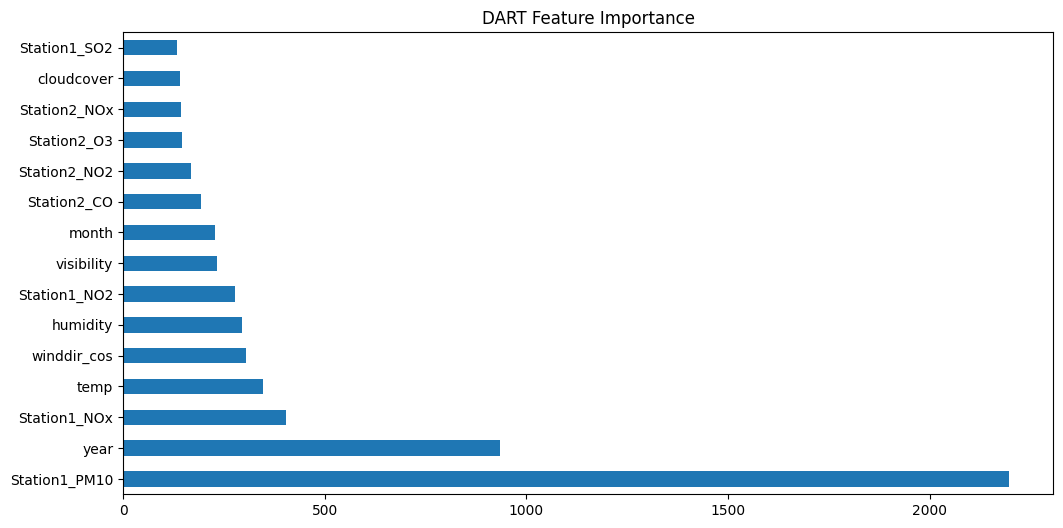

In [10]:
dart_pred = dart.predict(X_test_scaled)
dart_mse = mean_squared_error(y_test, dart_pred)
dart_mae = mean_absolute_error(y_test, dart_pred)
dart_r2 = r2_score(y_test, dart_pred)

print(f"\nDART Performance:")
print(f"MSE: {dart_mse:.4f}")
print(f"MAE: {dart_mae:.4f}")
print(f"R2: {dart_r2:.4f}")

plt.figure(figsize=(12, 6))
feat_importances = pd.Series(dart.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('DART Feature Importance')
plt.show()

In [11]:
print("Training LightGBM model...")
lgbm = LGBMRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)
lgbm.fit(X_train_scaled, y_train)

Training LightGBM model...


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=5,
              n_estimators=300, random_state=42, subsample=0.8, verbose=-1)


LightGBM Performance:
MSE: 23.9965
MAE: 3.0982
R2: 0.7835


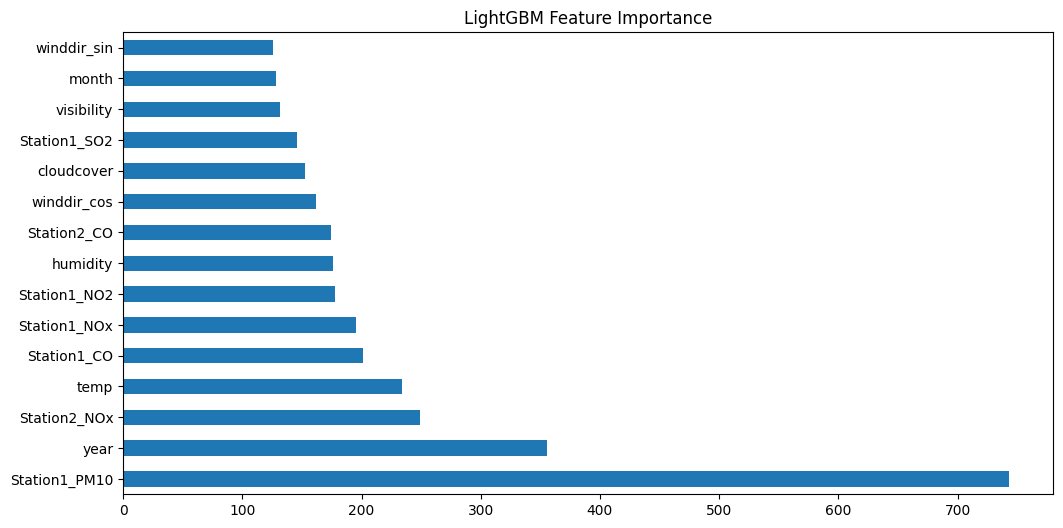

In [12]:
lgbm_pred = lgbm.predict(X_test_scaled)
lgbm_mse = mean_squared_error(y_test, lgbm_pred)
lgbm_mae = mean_absolute_error(y_test, lgbm_pred)
lgbm_r2 = r2_score(y_test, lgbm_pred)

print(f"\nLightGBM Performance:")
print(f"MSE: {lgbm_mse:.4f}")
print(f"MAE: {lgbm_mae:.4f}")
print(f"R2: {lgbm_r2:.4f}")

plt.figure(figsize=(12, 6))
feat_importances = pd.Series(lgbm.feature_importances_, index=features)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('LightGBM Feature Importance')
plt.show()

In [13]:
lstm_model = Sequential([
    LSTM(512, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.3),
    LSTM(256),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='mse',
                   metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training LSTM model...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 41s 907ms/step - loss: 485.3501 - mae: 16.4743 - val_loss: 97.7846 - val_mae: 7.5954
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 204.2224 - mae: 9.6304 - val_loss: 112.3805 - val_mae: 8.3624
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - loss: 217.3341 - mae: 10.0409 - val_loss: 115.4513 - val_mae: 8.5146
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 222.0546 - mae: 9.8666 - val_loss: 107.7281 - val_mae: 8.1626
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 877ms/step - loss: 200.2409 - mae: 9.1971 - val_loss: 84.9188 - val_mae: 7.3573
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 904ms/step - loss: 159.2541 - mae: 8.2587 - val_loss: 70.8261 - val_mae: 6.3008
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 880ms/step - loss: 140.6065 - mae: 8.1945 - val_loss: 73.4376 - val_mae: 6.4624
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 939ms/step - loss: 124.8880 - mae: 7.5413 - val_loss: 61.8357 - val_mae: 5.78

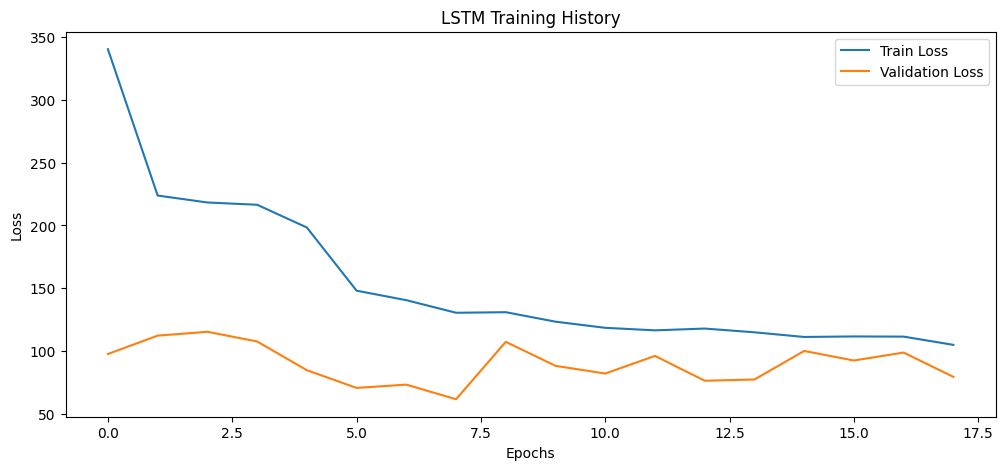

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step

LSTM Performance:
MSE: 65.0840
MAE: 5.9956
R2: 0.4239


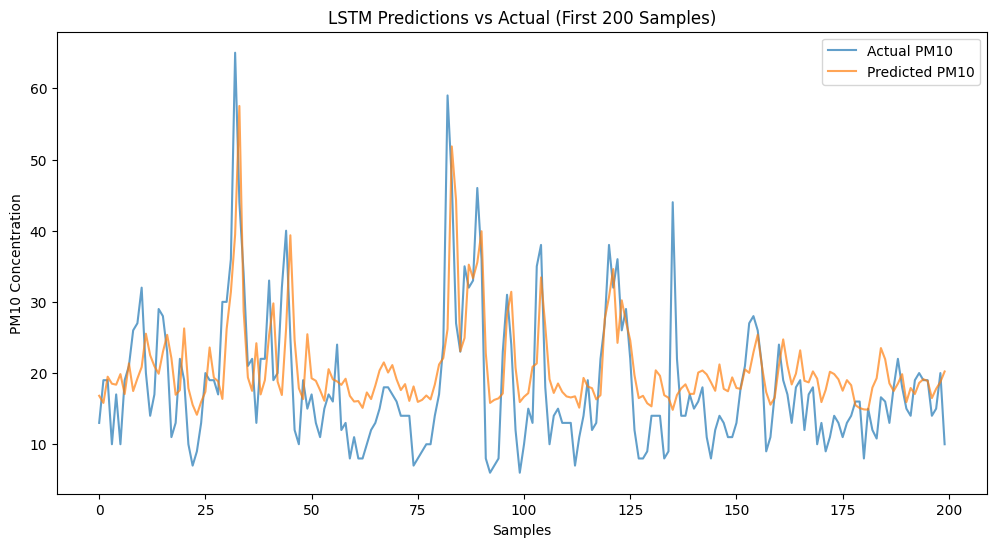

In [15]:
lstm_pred = lstm_model.predict(X_test_seq).flatten()
lstm_mse = mean_squared_error(y_test_seq, lstm_pred)
lstm_mae = mean_absolute_error(y_test_seq, lstm_pred)
lstm_r2 = r2_score(y_test_seq, lstm_pred)

print(f"\nLSTM Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"R2: {lstm_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:200], label='Actual PM10', alpha=0.7)
plt.plot(lstm_pred[:200], label='Predicted PM10', alpha=0.7)
plt.title('LSTM Predictions vs Actual (First 200 Samples)')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

In [16]:
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.3),
    GRU(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='mse',
                  metrics=['mae'])

print("Training GRU model...")
gru_history = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=150,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training GRU model...
Epoch 1/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - loss: 769.4136 - mae: 23.2658 - val_loss: 179.9134 - val_mae: 10.4951
Epoch 2/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 287.0164 - mae: 11.5529 - val_loss: 103.7412 - val_mae: 7.7566
Epoch 3/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 214.7209 - mae: 9.7775 - val_loss: 100.2528 - val_mae: 7.6640
Epoch 4/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 179.3116 - mae: 9.1335 - val_loss: 75.3084 - val_mae: 6.6470
Epoch 5/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 146.0942 - mae: 8.3184 - val_loss: 59.1072 - val_mae: 5.5379
Epoch 6/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - loss: 158.3280 - mae: 8.2996 - val_loss: 70.0955 - val_mae: 6.2160
Epoch 7/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 129.1446 - mae: 7.6407 - val_loss: 87.5261 - val_mae: 6.9095
Epoch 8/150
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 132.0228 - mae: 7.3197 - val_loss: 74.6392 - val_mae: 6.

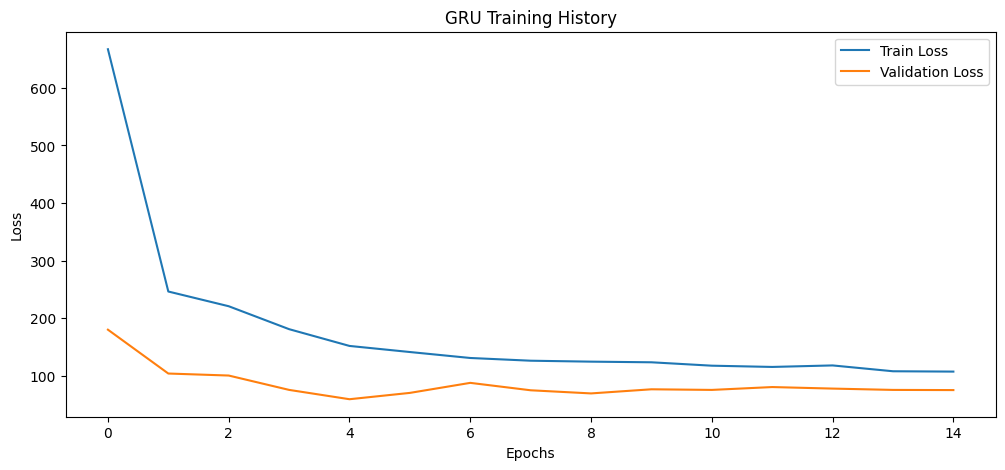

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

GRU Performance:
MSE: 82.4752
MAE: 6.3148
R2: 0.2700


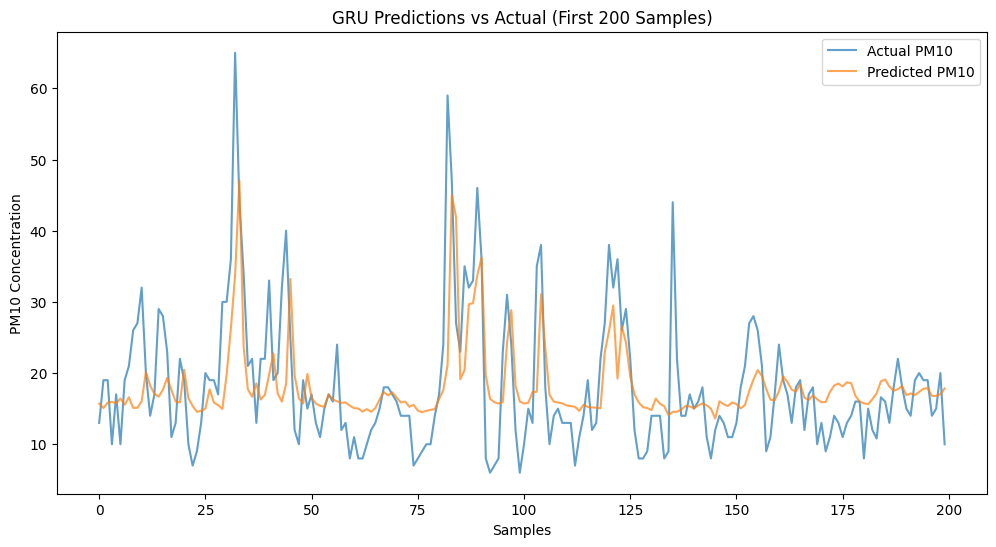

In [18]:
gru_pred = gru_model.predict(X_test_seq).flatten()
gru_mse = mean_squared_error(y_test_seq, gru_pred)
gru_mae = mean_absolute_error(y_test_seq, gru_pred)
gru_r2 = r2_score(y_test_seq, gru_pred)

print(f"\nGRU Performance:")
print(f"MSE: {gru_mse:.4f}")
print(f"MAE: {gru_mae:.4f}")
print(f"R2: {gru_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq[:200], label='Actual PM10', alpha=0.7)
plt.plot(gru_pred[:200], label='Predicted PM10', alpha=0.7)
plt.title('GRU Predictions vs Actual (First 200 Samples)')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

In [19]:
def get_meta_features(X_tree, X_seq, models):
    # Get tree model predictions
    tree_preds = {
        'gbdt': models['gbdt'].predict(X_tree),
        'dart': models['dart'].predict(X_tree),
        'lgbm': models['lgbm'].predict(X_tree)
    }

    # Get sequential model predictions
    seq_preds = {
        'lstm': models['lstm'].predict(X_seq).flatten(),
        'gru': models['gru'].predict(X_seq).flatten()
    }

    # Align predictions
    min_len = min(len(p) for p in [*tree_preds.values(), *seq_preds.values()])

    meta_X = np.column_stack([
        tree_preds['gbdt'][-min_len:],
        tree_preds['dart'][-min_len:],
        tree_preds['lgbm'][-min_len:],
        seq_preds['lstm'][-min_len:],
        seq_preds['gru'][-min_len:]
    ])

    return meta_X

In [20]:
meta_X_train = get_meta_features(X_train_scaled[time_steps:], X_train_seq,
                                 {'gbdt': gbdt, 'dart': dart, 'lgbm': lgbm,
                                  'lstm': lstm_model, 'gru': gru_model})
meta_y_train = y_train[time_steps:len(X_train_scaled[time_steps:]) + time_steps]

meta_X_test = get_meta_features(X_test_scaled[time_steps:], X_test_seq,
                                {'gbdt': gbdt, 'dart': dart, 'lgbm': lgbm,
                                 'lstm': lstm_model, 'gru': gru_model})
meta_y_test = y_test[time_steps:len(X_test_scaled[time_steps:]) + time_steps]

print(f"Meta-features training shape: {meta_X_train.shape}")
print(f"Meta-features test shape: {meta_X_test.shape}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Meta-features training shape: (3184, 5)
Meta-features test shape: (774, 5)


In [21]:
meta_model = Sequential([
    Dense(64, activation='relu', input_dim=meta_X_train.shape[1]),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

meta_model.compile(optimizer=Adam(learning_rate=0.001),
                   loss='mse')

print("Training meta-model...")
meta_history = meta_model.fit(
    meta_X_train, meta_y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Training meta-model...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 117.2593 - val_loss: 7.6173
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.9270 - val_loss: 5.3074
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.6735 - val_loss: 11.7116
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.5101 - val_loss: 10.1909
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.2124 - val_loss: 14.2501
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.3190 - val_loss: 15.8481
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4987 - val_loss: 15.4458
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.9382 - val_loss: 14.3848
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5134 - val_loss: 17.5766
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3359 - val_loss: 23.1602
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.5319 - val_loss: 25.7703
Epoch 12/100
40/40 ━━

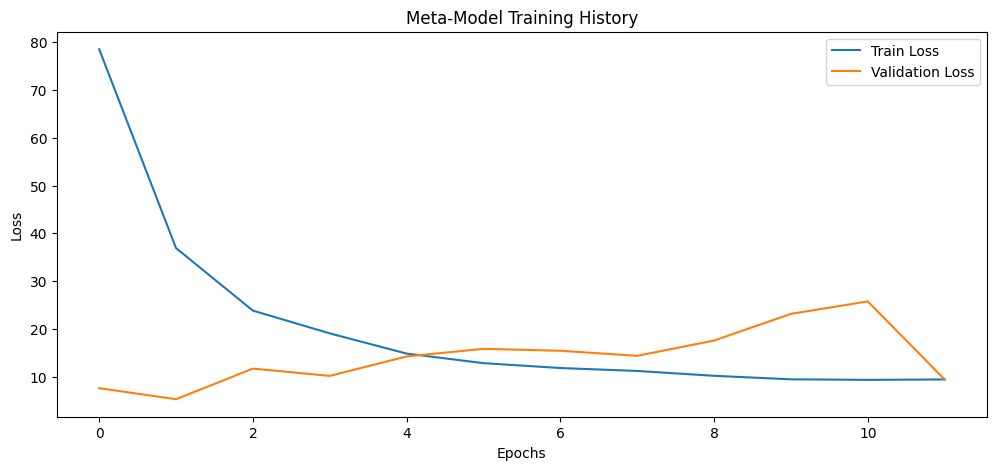

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(meta_history.history['loss'], label='Train Loss')
plt.plot(meta_history.history['val_loss'], label='Validation Loss')
plt.title('Meta-Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
base_results = {
    'GBDT': {'mse': gbdt_mse, 'mae': gbdt_mae, 'r2': gbdt_r2},
    'DART': {'mse': dart_mse, 'mae': dart_mae, 'r2': dart_r2},
    'LightGBM': {'mse': lgbm_mse, 'mae': lgbm_mae, 'r2': lgbm_r2},
    'LSTM': {'mse': lstm_mse, 'mae': lstm_mae, 'r2': lstm_r2},
    'GRU': {'mse': gru_mse, 'mae': gru_mae, 'r2': gru_r2}
}

# Display results
print("Base Model Performance:")
display(pd.DataFrame(base_results).T)

Base Model Performance:


,mse,mae,r2
GBDT,25.209158,3.254235,0.772580
DART,29.027509,3.424899,0.738133
LightGBM,23.996549,3.098153,0.783519
LSTM,65.084049,5.995558,0.423896
GRU,82.475171,6.314809,0.269955


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Ensemble Model Performance:
MSE: 29.6857
MAE: 3.4965
R2: 0.7372


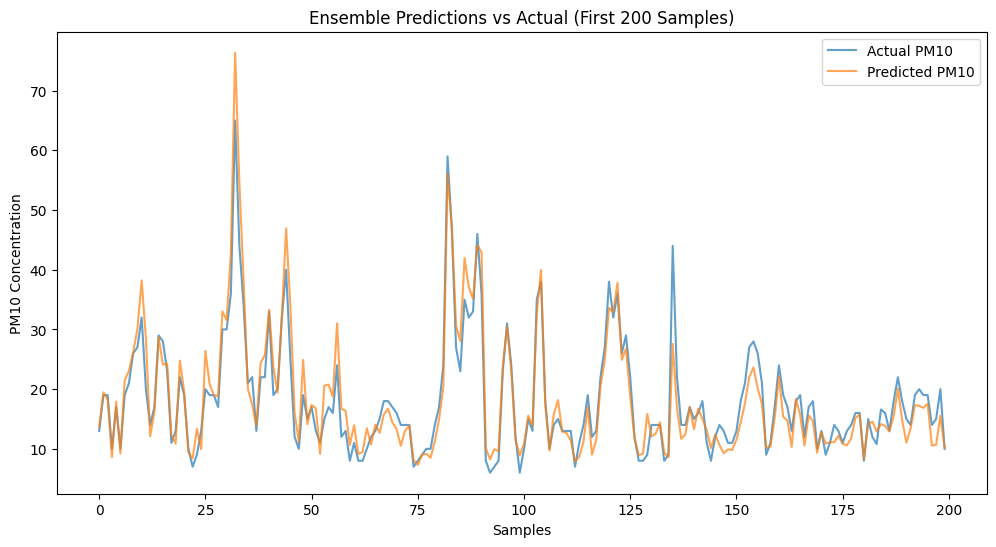

In [24]:
ensemble_pred = meta_model.predict(meta_X_test).flatten()
ensemble_mse = mean_squared_error(meta_y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(meta_y_test, ensemble_pred)
ensemble_r2 = r2_score(meta_y_test, ensemble_pred)

print("\nEnsemble Model Performance:")
print(f"MSE: {ensemble_mse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R2: {ensemble_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(meta_y_test[:200], label='Actual PM10', alpha=0.7)
plt.plot(ensemble_pred[:200], label='Predicted PM10', alpha=0.7)
plt.title('Ensemble Predictions vs Actual (First 200 Samples)')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()

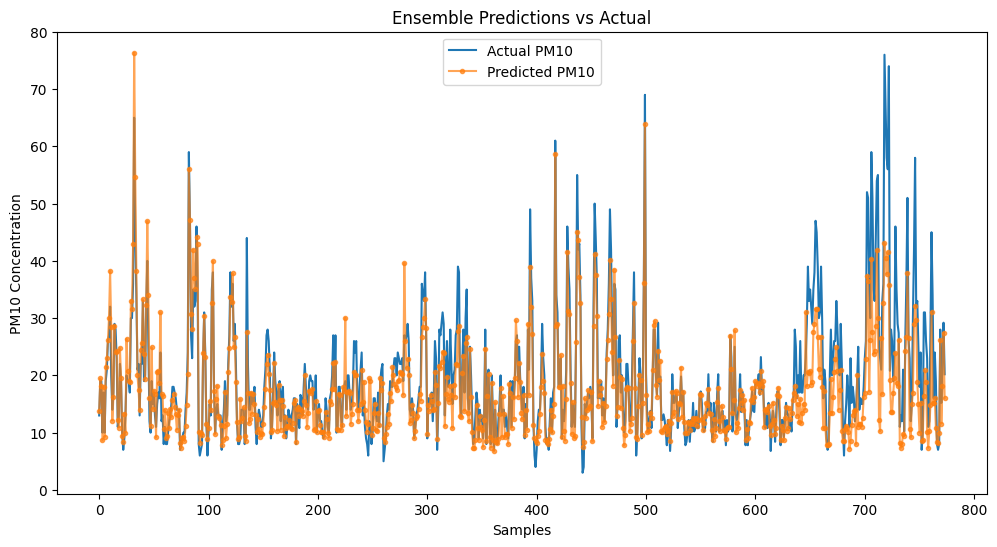

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(meta_y_test, label='Actual PM10')
plt.plot(ensemble_pred, label='Predicted PM10', alpha=0.7, marker='.')
plt.title('Ensemble Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.show()